In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import random
import os
import numpy as np


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

In [3]:
res = []
for file_path in glob.glob('../data/*.csv'):
    res.append(pd.read_csv(file_path))
df = pd.concat(res).sort_values('datetime').reset_index(drop=True)

In [4]:
df.head(3)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,final_opponent,datetime
0,蒼樹山,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,200001
1,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001
2,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001


In [5]:
df = df.dropna().reset_index(drop=True)

In [6]:
len(df)

4340

In [7]:
df.rename(columns={'day_15': 'final_day'}, inplace=True)
df['wins_at_day_14'] = df.iloc[:, df.columns.str.startswith('day_')].sum(axis=1)
# df.rename(columns={'final_day': 'day_15'}, inplace=True)

# features

In [8]:
df.head(2)

,wrestler,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,final_day,final_opponent,datetime,wins_at_day_14
0,金開山,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,和歌乃山,200001,6.0
1,魁皇,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,武双山,200001,7.0


## wins_till_final_day

In [9]:
def calc_wins_till_final_day(row):
    cnt = 0
    for i in range(14):
        if row.iloc[14 - i] == 1:
            cnt += 1
        else:
            return cnt
    return cnt


def calc_loses_till_final_day(row):
    cnt = 0
    for i in range(14):
        if row.iloc[14 - i] == 0:
            cnt += 1
        else:
            return cnt
    return cnt


df['wins_till_final_day'] = df.apply(calc_wins_till_final_day, axis=1)
df['loses_till_final_day'] = df.apply(calc_loses_till_final_day, axis=1)

In [10]:
df_list = []
for index, row in df.iterrows():
    _df = pd.DataFrame(row.iloc[1:15].T)
    _df.columns = ['results']
    _df['id'] = index
    df_list.append(_df)

df_tsf = pd.concat(df_list).reset_index(drop=True)
df_tsf['results'] = df_tsf['results'].astype(float)
df_tsf.head()

,results,id
0,1.0,0
1,0.0,0
2,0.0,0
3,1.0,0
4,1.0,0


In [11]:
from tsfresh import extract_features
extracted_features = extract_features(df_tsf, column_id='id')

Feature Extraction: 100%|██████████| 10/10 [02:12<00:00, 11.00s/it]


In [12]:
extracted_features.head()

variable,results__abs_energy,results__absolute_sum_of_changes,"results__agg_autocorrelation__f_agg_""mean""__maxlag_40","results__agg_autocorrelation__f_agg_""median""__maxlag_40","results__agg_autocorrelation__f_agg_""var""__maxlag_40","results__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","results__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","results__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","results__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","results__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,results__symmetry_looking__r_0.9,results__symmetry_looking__r_0.9500000000000001,results__time_reversal_asymmetry_statistic__lag_1,results__time_reversal_asymmetry_statistic__lag_2,results__time_reversal_asymmetry_statistic__lag_3,results__value_count__value_-1,results__value_count__value_0,results__value_count__value_1,results__variance,results__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,6.0,7.0,-0.128179,-0.102564,0.240665,1.0,0.0,0.0,0.0,NaN,...,1.0,1.0,0.000000,0.0,-0.125,0.0,8.0,6.0,0.244898,0.0
1,7.0,8.0,-0.030600,0.000000,0.282874,1.0,0.0,0.0,0.0,NaN,...,1.0,1.0,0.000000,-0.1,0.000,0.0,7.0,7.0,0.250000,0.0
2,11.0,5.0,-0.221478,-0.236364,0.129146,1.0,0.0,0.0,0.0,NaN,...,1.0,1.0,-0.083333,-0.1,-0.250,0.0,3.0,11.0,0.168367,0.0
3,7.0,8.0,-0.040174,0.000000,0.229328,1.0,0.0,0.0,0.0,NaN,...,1.0,1.0,0.000000,0.1,0.250,0.0,7.0,7.0,0.250000,0.0
4,9.0,6.0,-0.061907,0.029060,0.191730,1.0,0.0,0.0,0.0,NaN,...,1.0,1.0,0.000000,0.1,0.250,0.0,5.0,9.0,0.229592,0.0


In [13]:
df = pd.concat([df, extracted_features.reset_index(drop=True)], axis=1)

In [14]:
split_datetime = 201501
train = df[df['datetime']<split_datetime]
test = df[~(df['datetime']<split_datetime)]

In [15]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features.iloc[train.index])
features_filtered = select_features(extracted_features.iloc[train.index].dropna(axis=1), train['final_day'])

 'results__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'results__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'results__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'results__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'results__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'results__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'results__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'results__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'results__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'results__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'results__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'results__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'results__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'results__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"slope

/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/pandas/core/generic.py:7772: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors, try_cast=try_cast)


In [16]:
features_filtered.columns, len(features_filtered.columns)

(Index(['results__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
        'results__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
        'results__symmetry_looking__r_0.1',
        'results__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.4',
        'results__symmetry_looking__r_0.05', 'results__symmetry_looking__r_0.2',
        'results__symmetry_looking__r_0.15000000000000002',
        'results__ratio_beyond_r_sigma__r_1',
        'results__symmetry_looking__r_0.25'],
       dtype='object', name='variable'), 9)

# benchmark

In [17]:
TRAIN_COL = list(df.iloc[:, df.columns.str.startswith('day_')].columns) + list(features_filtered.columns) + [
    'wins_at_day_14',
    'wins_till_final_day',
    'loses_till_final_day',
    'wrestler',
    'final_opponent',
    'datetime'
]
# TRAIN_COL = list(set(train.columns) - set(['wrestler', 'final_day', 'final_opponent', 'datetime']))
TARGET = 'final_day'

X_train = train[TRAIN_COL]
X_test = test[TRAIN_COL]

y_train = train[TARGET]
y_test = test[TARGET]

In [18]:
X_train.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,results__symmetry_looking__r_0.2,results__symmetry_looking__r_0.15000000000000002,results__ratio_beyond_r_sigma__r_1,results__symmetry_looking__r_0.25,wins_at_day_14,wins_till_final_day,loses_till_final_day,wrestler,final_opponent,datetime
0,1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.428571,0.0,6.0,0,3,金開山,和歌乃山,200001
1,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.000000,1.0,7.0,0,1,魁皇,武双山,200001
2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.214286,1.0,11.0,0,1,曙,貴乃花,200001
3,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.000000,1.0,7.0,1,0,土佐ノ海,栃乃洋,200001
4,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.357143,0.0,9.0,1,0,千代大海,出島,200001


In [19]:
_tmp_train = X_train.drop('final_opponent', axis=1).rename(columns={'wrestler': 'final_opponent'})
_tmp_test = X_test.drop('final_opponent', axis=1).rename(columns={'wrestler': 'final_opponent'})

In [20]:
X_train = pd.merge(X_train, _tmp_train, on=['final_opponent', 'datetime'], how='left', suffixes=('_mine', '_opp'))
X_test = pd.merge(X_test, _tmp_test, on=['final_opponent', 'datetime'], how='left', suffixes=('_mine', '_opp'))

In [21]:
X_train.drop([ 'wrestler', 'final_opponent', 'datetime'], axis=1, inplace=True)
X_test.drop([ 'wrestler', 'final_opponent', 'datetime'], axis=1, inplace=True)

In [22]:
X_train.shape
assert X_train.shape[1] == X_test.shape[1]

In [23]:
import pandas as pd
import lightgbm as lgb


def lgbm(X_tr, X_val, y_tr, y_val, X_test, params, categorical_features):

    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=categorical_features)

    model = lgb.train(
        params, lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=10000,
        early_stopping_rounds=30,
        verbose_eval=10
    )

    y_valid = model.predict(X_val)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns.values
    fold_importance_df["importance"] = model.feature_importance(importance_type='gain')

    return y_pred, y_valid, model, fold_importance_df


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [24]:
from sklearn.model_selection import KFold, TimeSeriesSplit
import seaborn as sns


lgbm_params = {
    'max_depth': 16,
    'num_leaves': 4,
    'min_data_in_leaf': 10,
    'objective': 'binary',
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "feature_fraction": 0.7,
    "bagging_freq": 1,
    "bagging_fraction": 0.7,
    "metric": 'auc',
    "lambda_l1": 0.3,
    "verbosity": -1,
    "random_state": 42,
  }

categorical_features = list(X_train.iloc[:, X_train.columns.str.startswith('day_')].columns)

METRIC = 'auc'

In [25]:
train_basho, valid_basho = np.split(train['datetime'].unique(), [59])
len(valid_basho)

28

In [26]:
y_preds = []
models = []
feature_importances = pd.DataFrame()
# oof_train = np.zeros((len(X_train),))

for split_index in range(30, 60):

    train_basho, valid_basho = np.split(train['datetime'].unique(), [split_index])
    valid_basho = valid_basho[0:28]

    X_tr = X_train[train['datetime'].isin(train_basho)]
    X_val = X_train[train['datetime'].isin(valid_basho)]

    y_tr = y_train[train['datetime'].isin(train_basho)]
    y_val = y_train[train['datetime'].isin(valid_basho)]

    y_pred, y_val, model, fold_importance_df = lgbm(
        X_tr, X_val, y_tr, y_val, X_test, lgbm_params, categorical_features
    )

#     oof_train[valid_index] = y_val
    y_preds.append(y_pred)
    models.append(model)
    feature_importances = pd.concat([feature_importances, fold_importance_df], axis=0)


/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/shotaroishihara/project/sumo-predictor/env/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.624273	valid_1's auc: 0.583978
[20]	training's auc: 0.681202	valid_1's auc: 0.600374
[30]	training's auc: 0.697583	valid_1's auc: 0.589197
[40]	training's auc: 0.706847	valid_1's auc: 0.594845
[50]	training's auc: 0.723992	valid_1's auc: 0.583739
Early stopping, best iteration is:
[24]	training's auc: 0.684017	valid_1's auc: 0.603389
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.63348	valid_1's auc: 0.599893
[20]	training's auc: 0.677822	valid_1's auc: 0.605779
[30]	training's auc: 0.696556	valid_1's auc: 0.606468
[40]	training's auc: 0.70331	valid_1's auc: 0.59971
Early stopping, best iteration is:
[19]	training's auc: 0.671613	valid_1's auc: 0.610124
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.629075	valid_1's auc: 0.602966
[20]	training's auc: 0.659442	valid_1's auc: 0.612771
[30]	training's auc: 0.67828	valid_1's auc: 0

Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.621056	valid_1's auc: 0.56203
[20]	training's auc: 0.636566	valid_1's auc: 0.559698
[30]	training's auc: 0.650701	valid_1's auc: 0.560174
[40]	training's auc: 0.65637	valid_1's auc: 0.56333
[50]	training's auc: 0.666298	valid_1's auc: 0.56602
[60]	training's auc: 0.678266	valid_1's auc: 0.569261
[70]	training's auc: 0.686916	valid_1's auc: 0.567337
[80]	training's auc: 0.694154	valid_1's auc: 0.566507
[90]	training's auc: 0.704445	valid_1's auc: 0.564457
Early stopping, best iteration is:
[62]	training's auc: 0.680074	valid_1's auc: 0.570561
Training until validation scores don't improve for 30 rounds.
[10]	training's auc: 0.60881	valid_1's auc: 0.550128
[20]	training's auc: 0.637488	valid_1's auc: 0.566495
[30]	training's auc: 0.648482	valid_1's auc: 0.565674
[40]	training's auc: 0.653891	valid_1's auc: 0.572059
[50]	training's auc: 0.664578	valid_1's auc: 0.576441
[60]	training's auc: 0.679715	valid_

In [27]:
scores = [
    m.best_score['valid_1'][METRIC] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(score)
print(scores)

===CV scores===
0.5861269793964236
[0.603388637404683, 0.610123908377988, 0.6154492992029101, 0.5996155947289177, 0.6147000615121286, 0.5988488488488488, 0.60881562996055, 0.5933519850786038, 0.5942549944879137, 0.5963771043771043, 0.5908179012345679, 0.5783160319069056, 0.5724398901614092, 0.5839772332986362, 0.5660785469513353, 0.5788130916923732, 0.5657318432788278, 0.5930832851320714, 0.5823032181989215, 0.5917605797679598, 0.5816832507459505, 0.570561017929439, 0.5811803037190151, 0.5846370296370297, 0.5765847664202293, 0.5717509510559073, 0.5640273819765567, 0.5681796717418728, 0.570135155759806, 0.5768221673042419]


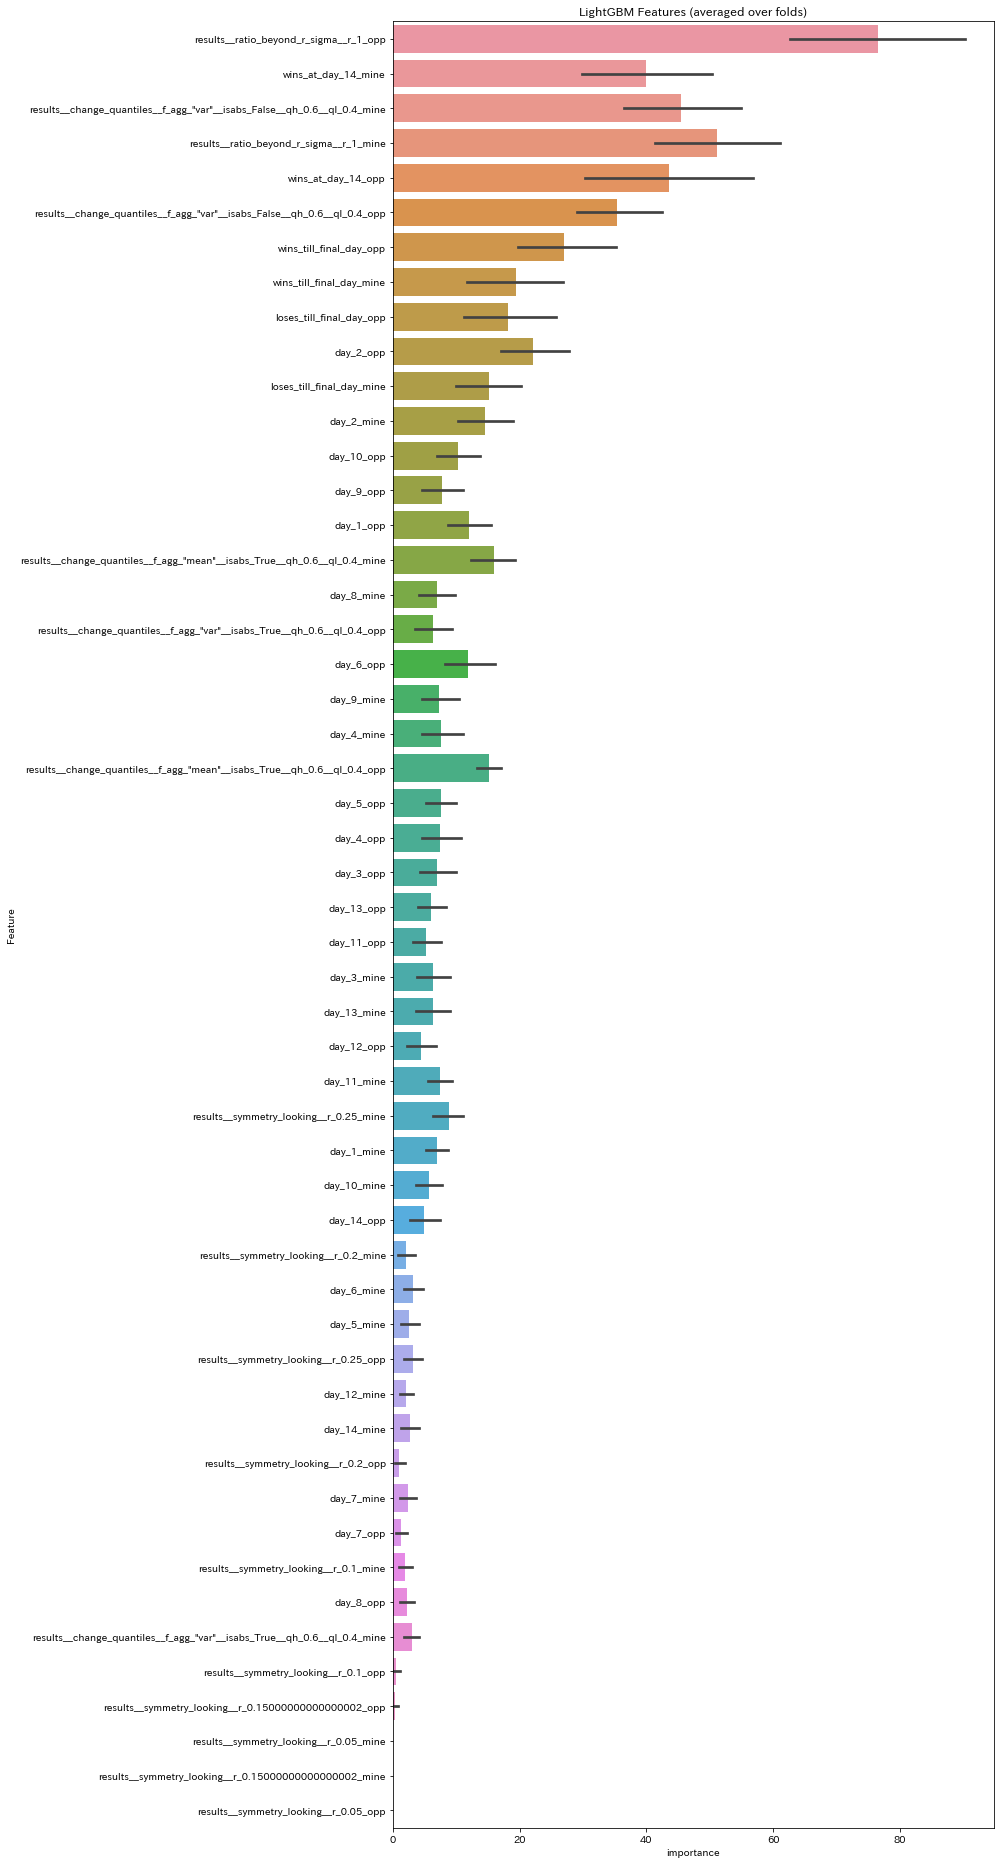

In [28]:
cols = feature_importances.groupby('Feature').mean().sort_values(by="importance", ascending=False)[:200].index

best_features = feature_importances.loc[feature_importances.Feature.isin(cols)]
plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [29]:
y_sub = sum(y_preds) / len(y_preds)
y_sub[:10]

array([0.47727144, 0.31809208, 0.42879984, 0.37182933, 0.46958219,
       0.41121888, 0.55222055, 0.46514835, 0.62350534, 0.51044702])

(array([ 18.,  24.,  74., 108., 390., 281.,  88.,  41.,   6.,  20.]),
 array([0.27411704, 0.32087399, 0.36763093, 0.41438788, 0.46114482,
        0.50790177, 0.55465871, 0.60141566, 0.6481726 , 0.69492955,
        0.74168649]),
 <a list of 10 Patch objects>)

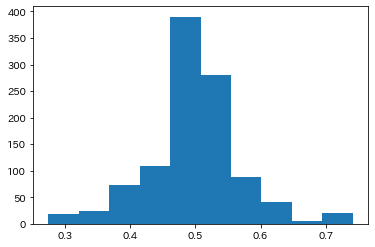

In [30]:
plt.hist(y_sub)

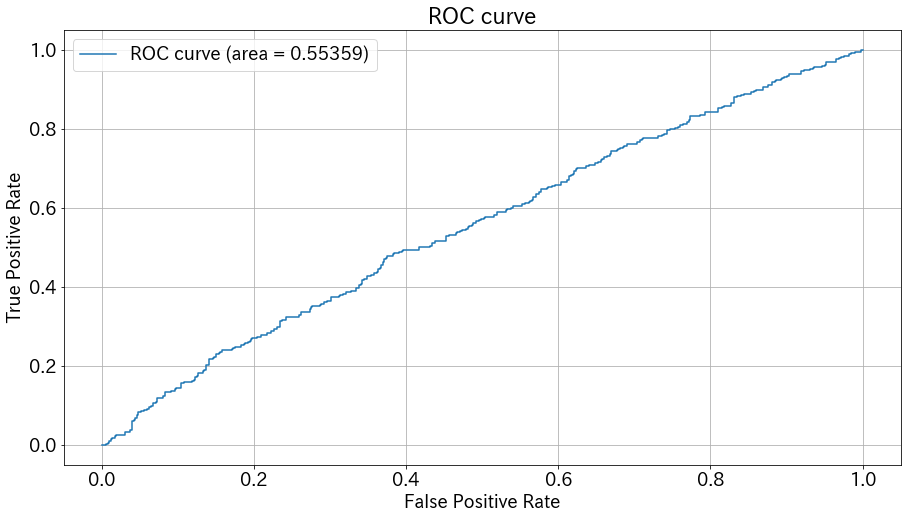

In [31]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_sub)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(15, 8))
plt.rcParams["font.size"] = 18
plt.plot(fpr, tpr, label='ROC curve (area = %.5f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [32]:
y_sub = np.where(y_sub > 0.5, 1, 0)
y_sub[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1])

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_sub)

array([[283, 237],
       [248, 282]])

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_sub)

0.5380952380952381